# Sentiment Analysis

Outline:
1. Perform an initial training using data available.
    1. Create x and y data using vectorizer.
    2. split test and train data
    3. Discuss results. Is it overfit? overconfident?


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np


review_day_1,review_day_2,review_day_3 = 'reviews_day_1.csv','reviews_day_2.csv','reviews_day_3.csv'
df1,df2,df3 = pd.read_csv(review_day_1, delimiter='\t'), pd.read_csv(review_day_2, delimiter='\t'), pd.read_csv(review_day_3, delimiter='\t')
dfs = pd.concat([df1,df2,df3], ignore_index=True)
dfs.head(5)

,content,title,author,date,rating,imdb_ID
0,"Toy Story is just a wonderful film, that I rec...",Toy story,ur20552756,16 June 2009,10.0,114709
1,Toy Story (1995) *** 1/2 (out of 4) A kid's to...,Toy story,ur13134536,22 December 2010,-1.0,114709
2,I can see why this was a big hit at the time. ...,Toy story,ur0482513,18 September 2021,6.0,114709
3,Andy's toys come to life. Woody (Tom Hanks) is...,Toy story,ur2898520,25 November 2013,10.0,114709
4,What a wonderful integration of classic toys a...,Toy story,ur0278527,3 January 2015,10.0,114709


In [2]:
# Before cleaning lets see how bad it is
print(len(dfs[dfs.rating == -1]))
print(len(dfs))
print(len(dfs[dfs.rating == 'NaN']))
print('ratio of bad data:', str(2984/18662)[0:5])
dfs.head(5)

5961
37774
0
ratio of bad data: 0.159


,content,title,author,date,rating,imdb_ID
0,"Toy Story is just a wonderful film, that I rec...",Toy story,ur20552756,16 June 2009,10.0,114709
1,Toy Story (1995) *** 1/2 (out of 4) A kid's to...,Toy story,ur13134536,22 December 2010,-1.0,114709
2,I can see why this was a big hit at the time. ...,Toy story,ur0482513,18 September 2021,6.0,114709
3,Andy's toys come to life. Woody (Tom Hanks) is...,Toy story,ur2898520,25 November 2013,10.0,114709
4,What a wonderful integration of classic toys a...,Toy story,ur0278527,3 January 2015,10.0,114709


In [3]:
# Remove -1
dfs = dfs.drop(dfs[dfs.rating == -1].index)

In [4]:
#The ratings given are a continuous variable. We convert it to a Boolean Y value for NB Classifier.
# if rating>8, it is'Fresh' i.e. a favourable rating/review. for NB classifier.

dfs['Fresh'] = pd.to_numeric(dfs.rating > 5.0)
#Note if rating greater than 8, this is represented as 1.

In [5]:
def make_XY(dfs,SPECIAL_FUNCTION_VARIABLE=None): 
    """Vectorizes then returns X and Y"""
    if SPECIAL_FUNCTION_VARIABLE is None:
        SPECIAL_FUNCTION_VARIABLE = CountVectorizer()
        
    X = SPECIAL_FUNCTION_VARIABLE.fit_transform(dfs.content) #vectorises the data.
    X = X.tocsc()  # some versions of sklearn return COO format
    
    Y = (dfs.Fresh).values.astype(int)
    return X, Y

In [6]:
#split the test and train data.
from sklearn.feature_extraction.text import CountVectorizer

# Use countvectoriser to Y, get X from labels.
X,Y = make_XY(dfs)

#Split data
x_train,x_test,y_train,y_test = train_test_split(X,Y)

In [7]:
print(y_train)

[1 1 1 ... 0 1 1]


In [8]:
#This is correct. 
#Training involves 
clf = MultinomialNB().fit(X = x_train , y = y_train)

training_accuracy = clf.score(x_train , y_train)
testing_accuracy = clf.score(x_test , y_test)

print (f'The average score for the training data is {str(training_accuracy*100)[:5]}%. The score for the test data is {str(testing_accuracy*100)[:5]}%')

The average score for the training data is 88.20%. The score for the test data is 80.60%


#### Interpretation
The percentage error on the test data (23.29%) is significantly larger than the error on the training data (13.71%). This indicates that the model is overfit. The difference in accuracy could also be a result of randomness, i.e. the choice of train and test data. (However, this is quite unlikely.) 



#### Is the model Overfit?

To test that overfitting has really occurred, cross-validation can be carried out. This involves using different test/train splits and training/scoring them. If the score of the prediction is consistently and significantly worse than the training score, then my model is overfit.

In [9]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [10]:
# Cross-validation

n_fold = 30
KF_object = KFold(n_splits=n_fold)

X,Y = make_XY(dfs)

difference_list = []

for train_index, test_index in KF_object.split(X):
    # Step 1 : select train test splits from vectorized X data and Y boolean data.  
    x_train =X[train_index]
    x_test = X[test_index]
    y_train =Y[train_index]
    y_test= Y[test_index]

    # Step 2 : train model and score against training and testing data.
    
    clf = MultinomialNB().fit(x_train , y_train)

    training_accuracy = clf.score(x_train , y_train)
    testing_accuracy = clf.score(x_test , y_test)
    
    error_ratio=(1-testing_accuracy)/(1-training_accuracy)
    #testing error is bigger if overfit. testing error/training error = error ratio
    
    difference_list.append(error_ratio)

In [11]:
print(difference_list)

[1.8153961447562876, 1.7843829627853058, 2.368152511024728, 2.2637121019283555, 1.5655681053971544, 2.043786861847492, 1.9680909273084901, 1.591524640837322, 1.5555399876137876, 1.9308710279492558, 1.7530068246596189, 1.5581267333842153, 0.9286128675091281, 1.5650060245912858, 1.323779850174436, 1.199312233718807, 1.1201377765711964, 1.4255600482827941, 1.7879091441681156, 1.6818703855619352, 1.7094886386935975, 1.7834257246707697, 1.6854475284578208, 1.7619352291039907, 1.810184968874109, 1.4332405942831314, 2.195752413767689, 1.7695522734302498, 1.8028653631083373, 1.6959298024246436]


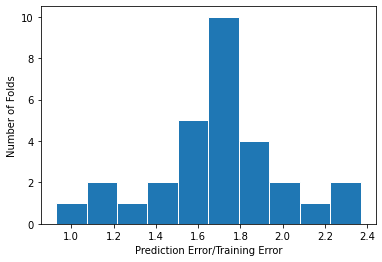

In [12]:
# Step 3 : plot histogram

plt.xlabel("Prediction Error/Training Error")
plt.ylabel("Number of Folds")

plt.hist(difference_list,edgecolor='white')
plt.show()

Across 30 different folds, the testing score is between 0.2 to 1.4 times more inaccurate than the training score. This shows that the model is overfit. 

#### Model Calibration

In this section, the probabilities caluclated by the NB classifier will be callibrated. I.e. Does a prediction P(X) = A% result in A% success empirically?
Two graphs will be made:
1. The first one is a histogram of the predicted probabilities for all reviews.
2. The second is a plot of Actual ratio of fresh reviews against P(fresh reviews) for different probability bins.


In [13]:
clf.classes_ #the first is P(rotten review)
#The second is P(fresh review)

array([0, 1])

In [14]:
X,Y = make_XY(dfs)
x_train,x_test,y_train,y_test = train_test_split(X,Y)
clf = MultinomialNB().fit(x_train , y_train)


#def calibration_plot(clf, x_test, y_test):
    
prediction = clf.predict_proba(x_test) #list of p(loss),p(win))
prediction = prediction[:,1] #get p(fresh only)
outcome=y_test

plot_data = pd.DataFrame(dict(prediction=prediction,outcome=outcome))

# Bin the predicted probabilities
bin_ends = np.linspace(0,1,21)
plot_data['categories'] = pd.cut(plot_data.prediction,bins=bin_ends,include_lowest=True,precision=4)

#Obtain the number of outcomes per bin and ratio of fresh outcomes
plot_data_2 = plot_data.groupby('categories')['outcome'].agg(['mean', 'count'])

In [15]:
plot_data_2.head()

,mean,count
categories,,
"(-0.0001, 0.05]",0.322733,1478
"(0.05, 0.1]",0.507812,128
"(0.1, 0.15]",0.559140,93
"(0.15, 0.2]",0.588235,51
"(0.2, 0.25]",0.720000,50


In [16]:
#variables and Error bars (For second plot)

#Error bars will be located in the middle of each bin.
plot_data_2['x_mid'] = np.linspace(0.025,1.025,21)[:-1]
plot_data_2['uncertainty'] = np.sqrt(1.96*1.96*plot_data_2.x_mid * (1 - plot_data_2.x_mid) / plot_data_2['count'])



In [17]:
plot_data_2.head(2)

,mean,count,x_mid,uncertainty
categories,,,,
"(-0.0001, 0.05]",0.322733,1478,0.025,0.00796
"(0.05, 0.1]",0.507812,128,0.075,0.04563


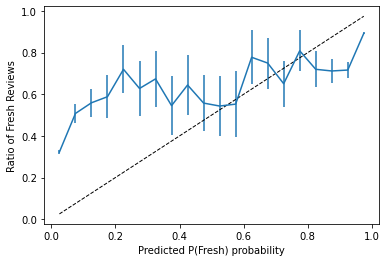

In [18]:
#Plot1 - bar chart

plt.errorbar(plot_data_2.x_mid, plot_data_2['mean'], plot_data_2.uncertainty, dash_capstyle = 'butt')#x,y,error,...

plt.ylabel("Ratio of Fresh Reviews")
plt.xlabel("Predicted P(Fresh) probability")

#For straight line
plt.plot(plot_data_2.x_mid, plot_data_2.x_mid, ls='--', lw=1, color='k')

Text(0, 0.5, 'Number of reviews in category')

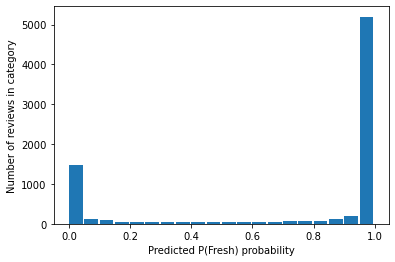

In [19]:
#Plot 2

plt.bar(align='edge', x=plot_data_2.x_mid - 0.05/ 2, height=plot_data_2['count'],width=.90 * (bin_ends[1] - bin_ends[0]))

plt.xlabel("Predicted P(Fresh) probability")
plt.ylabel("Number of reviews in category")

In [20]:
# Function for later
def calibration_plot(clf, x_test, y_test):
    
    #Build Dataframe containing probabilities and the actual outcome for each review
    prediction = clf.predict_proba(x_test) #list of p(loss),p(win))
    prediction = prediction[:,1] #get p(fresh only)
    outcome=y_test
    plot_data = pd.DataFrame(dict(prediction=prediction,outcome=outcome))

    # Bin the predicted probabilities
    bin_ends = np.linspace(0,1,21)
    plot_data['categories'] = pd.cut(plot_data.prediction,bins=bin_ends,include_lowest=True,precision=4)

    #Obtain the number of outcomes per bin and ratio of fresh outcomes
    plot_data_2 = plot_data.groupby('categories')['outcome'].agg(['mean', 'count'])

    #variables and Error bars (For second plot)
    #Error bars will be located in the middle of each bin.
    plot_data_2['x_mid'] = np.linspace(0.025,1.025,21)[:-1]
    plot_data_2['uncertainty'] = np.sqrt(1.96*1.96*plot_data_2.x_mid * (1 - plot_data_2.x_mid) / plot_data_2['count'])
    
    #Plot1 - graph with error bars.

    plt.errorbar(plot_data_2.x_mid, plot_data_2['mean'], plot_data_2.uncertainty, dash_capstyle = 'butt')#x,y,error
    plt.ylabel("Ratio of Fresh Reviews")
    plt.xlabel("Predicted P(Fresh) probability")

    #For straight line
    plt.plot(plot_data_2.x_mid, plot_data_2.x_mid, ls='--', lw=1, c='k')
    
    #Plot 2 - bar chart
    plt.bar(align='edge', x=plot_data_2.x_mid - 0.05/ 2, height=plot_data_2['count'],width=.90 * (bin_ends[1] - bin_ends[0]))
    plt.xlabel("Predicted P(Fresh) probability")
    plt.ylabel("Number of reviews in category")

##### Calibration - Conclusion
A model is over-confident if the freshness fraction is usually closer to 0.5 than expected (that is, there is more uncertainty than the model predicted). Likewise, a model is under-confident if the probabilities are usually further away from 0.5.

This model is over-confident.

Looking at plot 1, for a properly calibrated model, one would expect 10% of the P(Fresh) = 0.1 reviews to actually be fresh. However, the actual freshness ratio is almost 40%. 
For reviews where P(Fresh) ~0.9, the actual freshness fraction is closer to 0.7. In other words, there is more uncertainty in the outcome than implied by the model.

In other words, the model is overconfident because it tends to the straight line y = 0.5.

### Cross Validation

Our Model is over-confident and over-plotted. Our model has two hyperparameters which can be optimised using crossvalidation.
1. **alpha** - is a "smoothing hyperparameter" in Multinomial Naive Bayes. Increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. Also for alpha greater than zero, it accounts for features not present in some reviews. If these features are not accounted for, the model will turn many probabilities to zero.
2. **min_df** is a hyperparameter of CountVectorizer. It will ignore words that appear very few times.

An algorithm is to be made that goes through a series of alpha and min_df values, and trains a model using these hyperparameters. 
The model is then tested, and its score is tested using a loglikelihood function.


In [21]:
#Numpy Recap (Querying)
import numpy as np
list1 = np.array([1,0,1,0,1,1,1,1])
list2 = list1==1
list3 = list1==0
print(list2.astype(int),list3.astype(int))

[1 0 1 0 1 1 1 1] [0 1 0 1 0 0 0 0]


In [22]:
#preliminary stuff for functions
x,y=make_XY(dfs)

In [23]:
def max_loglikelihood(clf,x,y):
    """input is x and y data. output is log_likelihood"""
    prob_table = clf.predict_log_proba(x) #generates log prob list
    bad = y == 0
    good = y == 1
    log_likelihood = prob_table[bad, 0].sum() + prob_table[good, 1].sum() # log likelihood of data set. bigger is better.

    log_likelihood

    return log_likelihood
max_loglikelihood(clf,x,y) 
# Likelihood can be in range 0 to 1. 
# Hence, Log likelihood values are then in range -Inf to 0.

-29946.29007044372

In [24]:
def get_score(clf, x, y, folds=5):
    #1 Splits data into folds
    #2 trains model based on candidate hyperparameters
    #3 determines loglikelihood of model.(And returns it)
    
    result = 0
    KF_object=KFold(n_splits=folds)
    for train_index,test_index in KF_object.split(x):
        x_train=x[train_index]
        y_train=y[train_index]
        clf.fit(x_train, y_train)
        result = result + max_loglikelihood(clf,x,y)

    return result
get_score(clf, x,y)
print(get_score(clf, x,y))

-155028.72437158128


Below are typical alpha and min_df values for the classifier. Obtained from [source](). This Gridsearch method is not efficient. There is a new [function](https://stackoverflow.com/questions/33830959/multinomial-naive-bayes-parameter-alpha-setting-scikit-learn) that can do this automatically. it's practically exhaustive.

In [25]:
#the grid of hyperparameters to search over (Next time use GridSearchCV)
#Plot the hyperparameters and the score.
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

In [26]:
#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas: 
    for min_df in min_dfs: #choose 1 alpha and 1 min_df
        
        #Convert data to a vector form using vectoriser
        vectorizer = CountVectorizer(min_df = min_df) 
        
        #Obtain your dataset x y
        X, Y = make_XY(dfs, vectorizer) #We took a long time to figure this out see changes in fucntion above
        
        #Function get_score does many things:
         ##1 Splits data into folds
         ##2 trains model based on candidate hyperparameters
         ##3 determines loglikelihood of model.(And returns it)
        
        #This is done outside, because the get_score function is generalised. This is supposed to be ##step 2
        clf = MultinomialNB(alpha=alpha) 
        loglike = get_score(clf, X, Y)

        if loglike > max_loglike:
            max_loglike = loglike
            best_alpha, best_min_df = alpha, min_df

C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha =

In [27]:
print(f'best alpha is: {best_alpha}')
print(f'best min_df is: {best_min_df}')

best alpha is: 0
best min_df is: 0.1


## Final Model
The best hyperparameters are used to train the model

Note: 
1. the best hyperparameters happen to be at the ends of the grid. This means that better values might be jsut outside the grid. The grid must be expanded to verify this.
2. There are better ways/methods to look for optimal hyperparameters.


In [28]:
# Cross-validation

n_fold = 5
KF_object = KFold(n_splits=n_fold)

vectorizer = CountVectorizer(min_df = 0.1) 
X,Y = make_XY(dfs, vectorizer)

difference_list = [] # list of the differences between the train and test score.

for train_index, test_index in KF_object.split(X):
    # Step 1 : select train test splits from vectorized X data and Y boolean data.  
    x_train =X[train_index]
    x_test = X[test_index]
    y_train =Y[train_index]
    y_test= Y[test_index]

    # Step 2 : train model and score against training and testing data.
    
    clf = MultinomialNB(alpha=0).fit(x_train , y_train)

    training_accuracy = clf.score(x_train , y_train)
    testing_accuracy = clf.score(x_test , y_test)
    
    error_ratio=(1-testing_accuracy)/(1-training_accuracy)
    #testing error is bigger if overfit. testing error/training error = error ratio
    
    difference_list.append(error_ratio)

C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


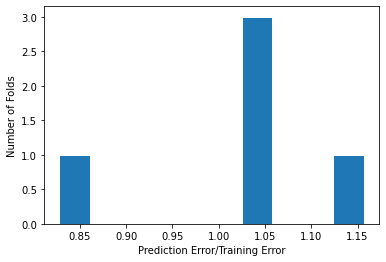

In [30]:
plt.xlabel("Prediction Error/Training Error")
plt.ylabel("Number of Folds")

plt.hist(difference_list,edgecolor='white')
plt.show()